Name: Kakhaev Ivan  
ID: 0860838  
  
Repo: [github.com/veax-void/digit_object_detection](https://github.com/veax-void/digit_object_detection)  
  
# Introduction
Data:   
For train data it's: *see_bboxes.m*, *digitStruct.mat* and images in .png format  
For test data it's: just images in .png format
  
Task:  
Predict bounding boxes of digits on images from "Google street view".  
  
For this task I will use the Faster-RCNN model, with no augmentation because given a lot of data with high variance.  
But I made an option for training with resized images.   
First of all, load libs and config file for this run.


In [1]:
import os
import copy
import json

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.transforms import functional as F

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN

from IPython.display import clear_output

from utils.collect_data import train_to_csv
from utils.engine import train_one_epoch, evaluate
import utils.utils


In [2]:
from configs.config import cfg

config_path = 'configs/experiment_1.yaml'
cfg.merge_from_file(config_path)
print(f'Config:\n{cfg}')


Config:
MODEL:
  N_CLASSES: 10
  TRANSFER: False
SYSTEM:
  NUM_WORKERS: 4
TRAIN:
  BATCH_SIZE: 4
  EPOCHS: 10
  MODEL_PATH: ./models/model_2.pth
  RESIZE_MODE: False
  RESIZE_SIZE: (64, 64)


# Data

I need to assemble data from original dataset and put it in *train_img_bbox_data.csv* for faster access.  
Data contained: filenames, coordinates of the bounding boxes, labels and image height.

## Loading

In [17]:
test_folder = './test'
img_folder = './train'
mat_file_name = 'digitStruct.mat'
csv_train_name = './outputs/train_img_bbox_data.csv'

if not os.path.exists(csv_train_name):
    print('Please wait for data to get ready...')
    train_to_csv(img_folder, mat_file_name, csv_train_name)

img_bbox_data = pd.read_csv(csv_train_name)
img_bbox_data.head()


,height,img_name,label,left,top,width,bottom,right
0,219.0,1.png,1.0,246.0,77.0,81.0,296.0,327.0
1,219.0,1.png,9.0,323.0,81.0,96.0,300.0,419.0
2,32.0,2.png,2.0,77.0,29.0,23.0,61.0,100.0
3,32.0,2.png,3.0,98.0,25.0,26.0,57.0,124.0
4,15.0,3.png,2.0,17.0,5.0,8.0,20.0,25.0


## Dataset
Digit_Dataset translating data about files *img_bbox_data* to sample that is valid for Faster-RCNN.

In [4]:
class Digit_Dataset(Dataset):
    def __init__(self, img_folder, img_bbox_data, transforms=None):
        self.img_bbox_data = img_bbox_data
        self.img_folder = img_folder
        self.transforms = transforms

    def __getitem__(self, idx):
        img_name = img_bbox_data['img_name'].unique()[idx]
        img = Image.open(self.img_folder+'/'+img_name).convert("RGB")

        target = {}
        target['boxes'] = []
        target['labels'] = []
        target['img_id'] = torch.tensor([int(img_name[:-4])])
        target['area'] = []
        target['iscrowd'] = []

        cond = self.img_bbox_data['img_name'] == img_name
        bb_data = self.img_bbox_data[cond]

        for i in range(bb_data.shape[0]):
            # [x0, y0, x1, y1]
            x0 = bb_data.iloc[i]['left']
            x1 = bb_data.iloc[i]['right']
            y0 = bb_data.iloc[i]['top']
            y1 = bb_data.iloc[i]['bottom']

            boxes = [x0, y0, x1, y1]
            target['boxes'] += [boxes]
            target['labels'] += [bb_data.iloc[i]['label'].astype('int') - 1]
            target['area'] += [(boxes[3] - boxes[1]) * (boxes[2] - boxes[0])]
            target['iscrowd'] += [0]

        target['boxes'] = torch.as_tensor(
            target['boxes'], dtype=torch.float32)
        target['labels'] = torch.as_tensor(
            target['labels'], dtype=torch.int64)
        target['area'] = torch.as_tensor(
            target['area'], dtype=torch.float32)
        target['iscrowd'] = torch.as_tensor(
            target['iscrowd'], dtype=torch.int64)

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return self.img_bbox_data['img_name'].unique().size


## Transforms
Here I just redefined basic transforms to handle new data format that will be returned by Dataset.

In [10]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


class Resize(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target):
        # img
        w, h = image.size
        image = image.resize(self.size)

        # Scale update
        x_scale = self.size[0] / w
        y_scale = self.size[1] / h

        # coords
        boxes = target['boxes']
        boxes[:, 0] *= x_scale
        boxes[:, 2] *= x_scale
        boxes[:, 1] *= y_scale
        boxes[:, 3] *= y_scale
        target['boxes'] = boxes

        # Areas
        a = (boxes[:, 3] - boxes[:, 1])
        b = (boxes[:, 2] - boxes[:, 0])
        target['area'] = a * b

        return image, target

transform = Compose([
    ToTensor()
])

test_transform = T.Compose([
    T.ToTensor()
])

if cfg.TRAIN.RESIZE_MODE:
    transform = Compose([
        Resize(cfg.TRAIN.RESIZE_SIZE),
        ToTensor()
    ])

    test_transform = T.Compose([
        T.Resize(cfg.TRAIN.RESIZE_SIZE),
        T.ToTensor()
    ])  

## Dataloader
Just use *collate_fn* to ensure that targets in dataloder will be right formating for the model. 

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_ds = Digit_Dataset(img_folder, img_bbox_data, transform)
train_dl = DataLoader(train_ds, batch_size=cfg.TRAIN.BATCH_SIZE,
                      shuffle=True, collate_fn=collate_fn, num_workers=cfg.SYSTEM.NUM_WORKERS)


# Model
Here you can see func *set_parameter_requires_grad* that will be used if *cfg.MODEL.TRANSFER* equals True, for setting the model into transfer learning mode.  
Then replacing old head of the model with a new one with number of classes of *cfg.MODEL.N_CLASSES*.

In [12]:
# This is to set modet to transfer learning mode
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    return model


In [13]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
if cfg.MODEL.TRANSFER:
    model = set_parameter_requires_grad(model, True)

# num_classes
num_classes = cfg.MODEL.N_CLASSES

# get number of input features
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace head
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


# Training
First of all setup device, if available, then sending model to the device.  
For optimizer will use SGD with simple scheduler *StepLR.*  
Then just train it for *cfg.TRAIN.EPOCHS* using coco_utils tools.  
After training save model to *cfg.TRAIN.MODEL_PATH*.  

In [14]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [10]:
# move model to the device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

for epoch in range(cfg.TRAIN.EPOCHS):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()

print("Done.")


Done.


In [16]:
# Save the model
torch.save(model.state_dict(), cfg.TRAIN.MODEL_PATH)


# Inference
I didn't use any validation because I got a lot of data and the model that I used actually had pretty decent results.  
First of all I prepare the model for inference and loaded test data.


In [15]:
''' Load model and prepare for inference '''
model.load_state_dict(torch.load(cfg.TRAIN.MODEL_PATH))

# move model to the right device
model.to(device)
model.eval()
print('Done.')


Done.


In [18]:
''' Loading test files '''
# Get filenames
test_files = os.listdir(test_folder)

# Sort filenames correctly
file_numbers = np.array([int(s[:-4]) for s in test_files])
sort_idxs = np.argsort(file_numbers)

test_files = np.array(test_files)[sort_idxs]
test_files


array(['1.png', '2.png', '3.png', ..., '13066.png', '13067.png',
       '13068.png'], dtype='<U9')

Above we can see that file names are sorted appropriately.  
  
Next function just swaps coordinates from (x0,y0,x1,y1) to (y0,x0,y1,x1), for submission formatting. 


In [19]:
def format_boxes(boxes):
    ''' Swap coordinates for submition function defeniton '''
    x0, y0, x1, y1 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    new_boxes = np.zeros_like(boxes)
    new_boxes[:, 0] = y0
    new_boxes[:, 1] = x0
    new_boxes[:, 2] = y1
    new_boxes[:, 3] = x1
    return new_boxes


This is actual inference loop for all test data.  
Here we get all prediction results and original image sizes for translating coordinates if we used *cfg.TRAIN.RESIZE_MODE.*   
After prediction just format bounding boxes to submission format for convenience.


In [20]:
''' Inference loop
    - Get predictions
    - Get original image sizes
'''

predictions = []
original_sizes = []

for i, fn in enumerate(test_files):
    img = Image.open(os.path.join(test_folder, fn))
    x = test_transform(img).unsqueeze(0)

    pred = model(x.to(device))

    boxes = pred[0]['boxes'].detach().cpu().numpy()
    labels = pred[0]['labels'].detach().cpu().numpy() + 1
    scores = pred[0]['scores'].detach().cpu().numpy()

    predictions += [[boxes, labels, scores]]
    if cfg.TRAIN.RESIZE_MODE:
        original_sizes += [img.size]

    clear_output(wait=True)
    print('[{}/{}]'.format(i, test_files.size))


[13067/13068]


In [23]:
''' Format predicted results '''
for i in range(len(predictions)):
    predictions[i][0] = format_boxes(predictions[i][0])


In [24]:
''' Look at predicted results '''
predictions[0]


[array([[ 7.477458, 40.425076, 40.705524, 59.823414]], dtype=float32),
 array([5]),
 array([0.9959733], dtype=float32)]

Above we can take a look at a sample of predicted formated results.  
  
Next I check inference time, and because it takes look time to predict 7 times for all test data I just used a small patch of it. 

In [30]:
# Load images
num_of_test_im = 5
time_test_images = []
for i, fn in enumerate(test_files[:num_of_test_im]):
    img = Image.open(os.path.join(test_folder, fn))
    x = test_transform(img).unsqueeze(0)
    time_test_images += [x]


In [31]:
%%timeit
# Check inference time
for i in range(num_of_test_im):
    pred = model(time_test_images[i].to(device))


333 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now just select only digits with a score above 0.45, and we get our submission.

In [58]:
''' Get predictions only with certainty above threshold value'''
sublission = []
threshold = 0.45

for pred in predictions:
    boxes = pred[0]
    labels = pred[1]
    scores = pred[2]

    cond = scores > threshold
    scores = scores[cond]
    boxes = boxes[cond]
    labels = labels[cond]

    prediction = {}
    prediction['bbox'] = boxes.tolist()
    prediction['score'] = scores.tolist()
    prediction['label'] = labels.tolist()

    sublission += [prediction]

len(sublission)


13068

This part will translate predicted coordinated to the sizes of original images if we used *cfg.TRAIN.RESIZE_MODE*.

In [25]:
def transform_coords(y0, x0, y1, x1, predicted_size, original_size):
    ''' Transforming coordinates function '''
    scales = original_size / predicted_size

    new_y0 = round(y0 * scales[1])
    new_x0 = round(x0 * scales[0])
    new_y1 = round(y1 * scales[1])
    new_x1 = round(x1 * scales[0])

    return new_y0, new_x0, new_y1, new_x1


In [61]:
''' Progect predicted coordinates from image size (64,64) to original size '''
os_sublission = copy.deepcopy(sublission)

if cfg.TRAIN.RESIZE_MODE:
    # size of train transformed images
    T_size = np.array(cfg.TRAIN.RESIZE_SIZE)

    for i, sample in enumerate(sublission):
        num_digits = len(sample['bbox'])

        original_size = np.array(original_sizes[i])

        for j in range(num_digits):
            y0, x0, y1, x1 = sample['bbox'][j]
            _y0, _x0, _y1, _x1 = transform_coords(
                y0, x0, y1, x1, T_size, original_size)
            os_sublission[i]['bbox'][j] = [_y0, _x0, _y1, _x1]

        # Print proogress
        clear_output(wait=True)
        print(f'[{i}/{len(sublission)}]')


Now just save prediction into submission file and we done.

In [72]:
''' Save prediction into json file '''
with open('outputs/sublission.json', 'w') as outfile:
    json.dump(os_sublission, outfile)


# Conclusion
Out of the shelf method Faster-RCNN performed really well, for training with resizing I get mAP=0.41 but without it I get mAP=0.44. That understandable because when I make images smaller they lose some information due resize interpolation.  
And as you can see from a picture below model pretty sure (0.66) that lantern is number 4.

P.S.  
I didn't put train loop into *train.py* file, because when TA said that I already finished this code, but for next homework I will separate them.


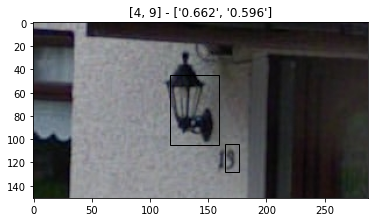

In [71]:
''' Plot original test images and predictions '''
img_idx = 12
digit_idx = 0

test_folder = './test'
original_img = Image.open(os.path.join(test_folder, test_files[img_idx]))

title = (str(os_sublission[img_idx]['label']) + ' - ' +
         str([str(s)[:5] for s in os_sublission[img_idx]['score']]))

plt.imshow(original_img)
plt.title(title)
currentAxis = plt.gca()
for coords in os_sublission[img_idx]['bbox']:
    _y0, _x0, _y1, _x1 = coords
    new_h = _y1 - _y0
    new_w = _x1 - _x0

    currentAxis.add_patch(Rectangle(
        (_x0, _y0), new_w, new_h, fill=None, alpha=1))
plt.show()
